# 📋 Exploratory Data Analysis (EDA)

In this notebook, we'll take a closer look at the dataset to understand its structure, patterns, relationships, and potential issues before moving on to modeling. This step is essential for getting a feel for the data and making informed decisions about feature selection and model design.


### 📋 Objectives:

- Understand the distribution of data and key statistics
- Identify missing values, outliers, and unusual patterns
- Examine relationships between features using visualizations
- Check class balance and label distribution
- Detect highly correlated features for potential feature selection

EDA helps uncover the story behind the data — so let's dive in and explore what it has to tell us! 📈✨

### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

###  2. Load Clean Data


In [2]:
# file path
clean_data_path = "../data/processed/clean_network_data.csv"

# Load the dataset
df = pd.read_csv(clean_data_path)

# Check shape 
print(f"Dataset Shape: {df.shape}")

#Display the first 5 records
df.head()


Dataset Shape: (223082, 61)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


## 3. Outlier Detection and Visualization

Outliers are data points significantly different from others in the dataset. They can result from:
- Data entry errors
- Sensor glitches
- Rare events (like attacks in NIDS)

### 📌 Why handle outliers?
- Outliers can skew feature distributions.
- They may impact model accuracy and stability.
- Some might represent rare but important events in intrusion detection, so careful analysis is needed.

We’ll detect outliers using the **Interquartile Range (IQR) method**, and visualize them using **histograms**.



#### 📊 Key features selected for outlier detection:

- Flow Duration
- Total Fwd/Backward Packets
- Total Length of Fwd/Bwd Packets
- Fwd/Bwd Packet Length Max
- Flow Bytes/s, Flow Packets/s
- Fwd/Bwd IAT Totals
- Packet Length Mean/Std/Variance
- Average Packet Size
- Init Window Bytes (Fwd/Back)
- Active and Idle durations

**Why these?**
- These numeric, continuous features are susceptible to extreme values.
- Outliers can distort model training, especially for distance-based models.
- In network intrusion data, extreme values might also indicate attacks — so we carefully visualize and decide whether to treat them or keep them.


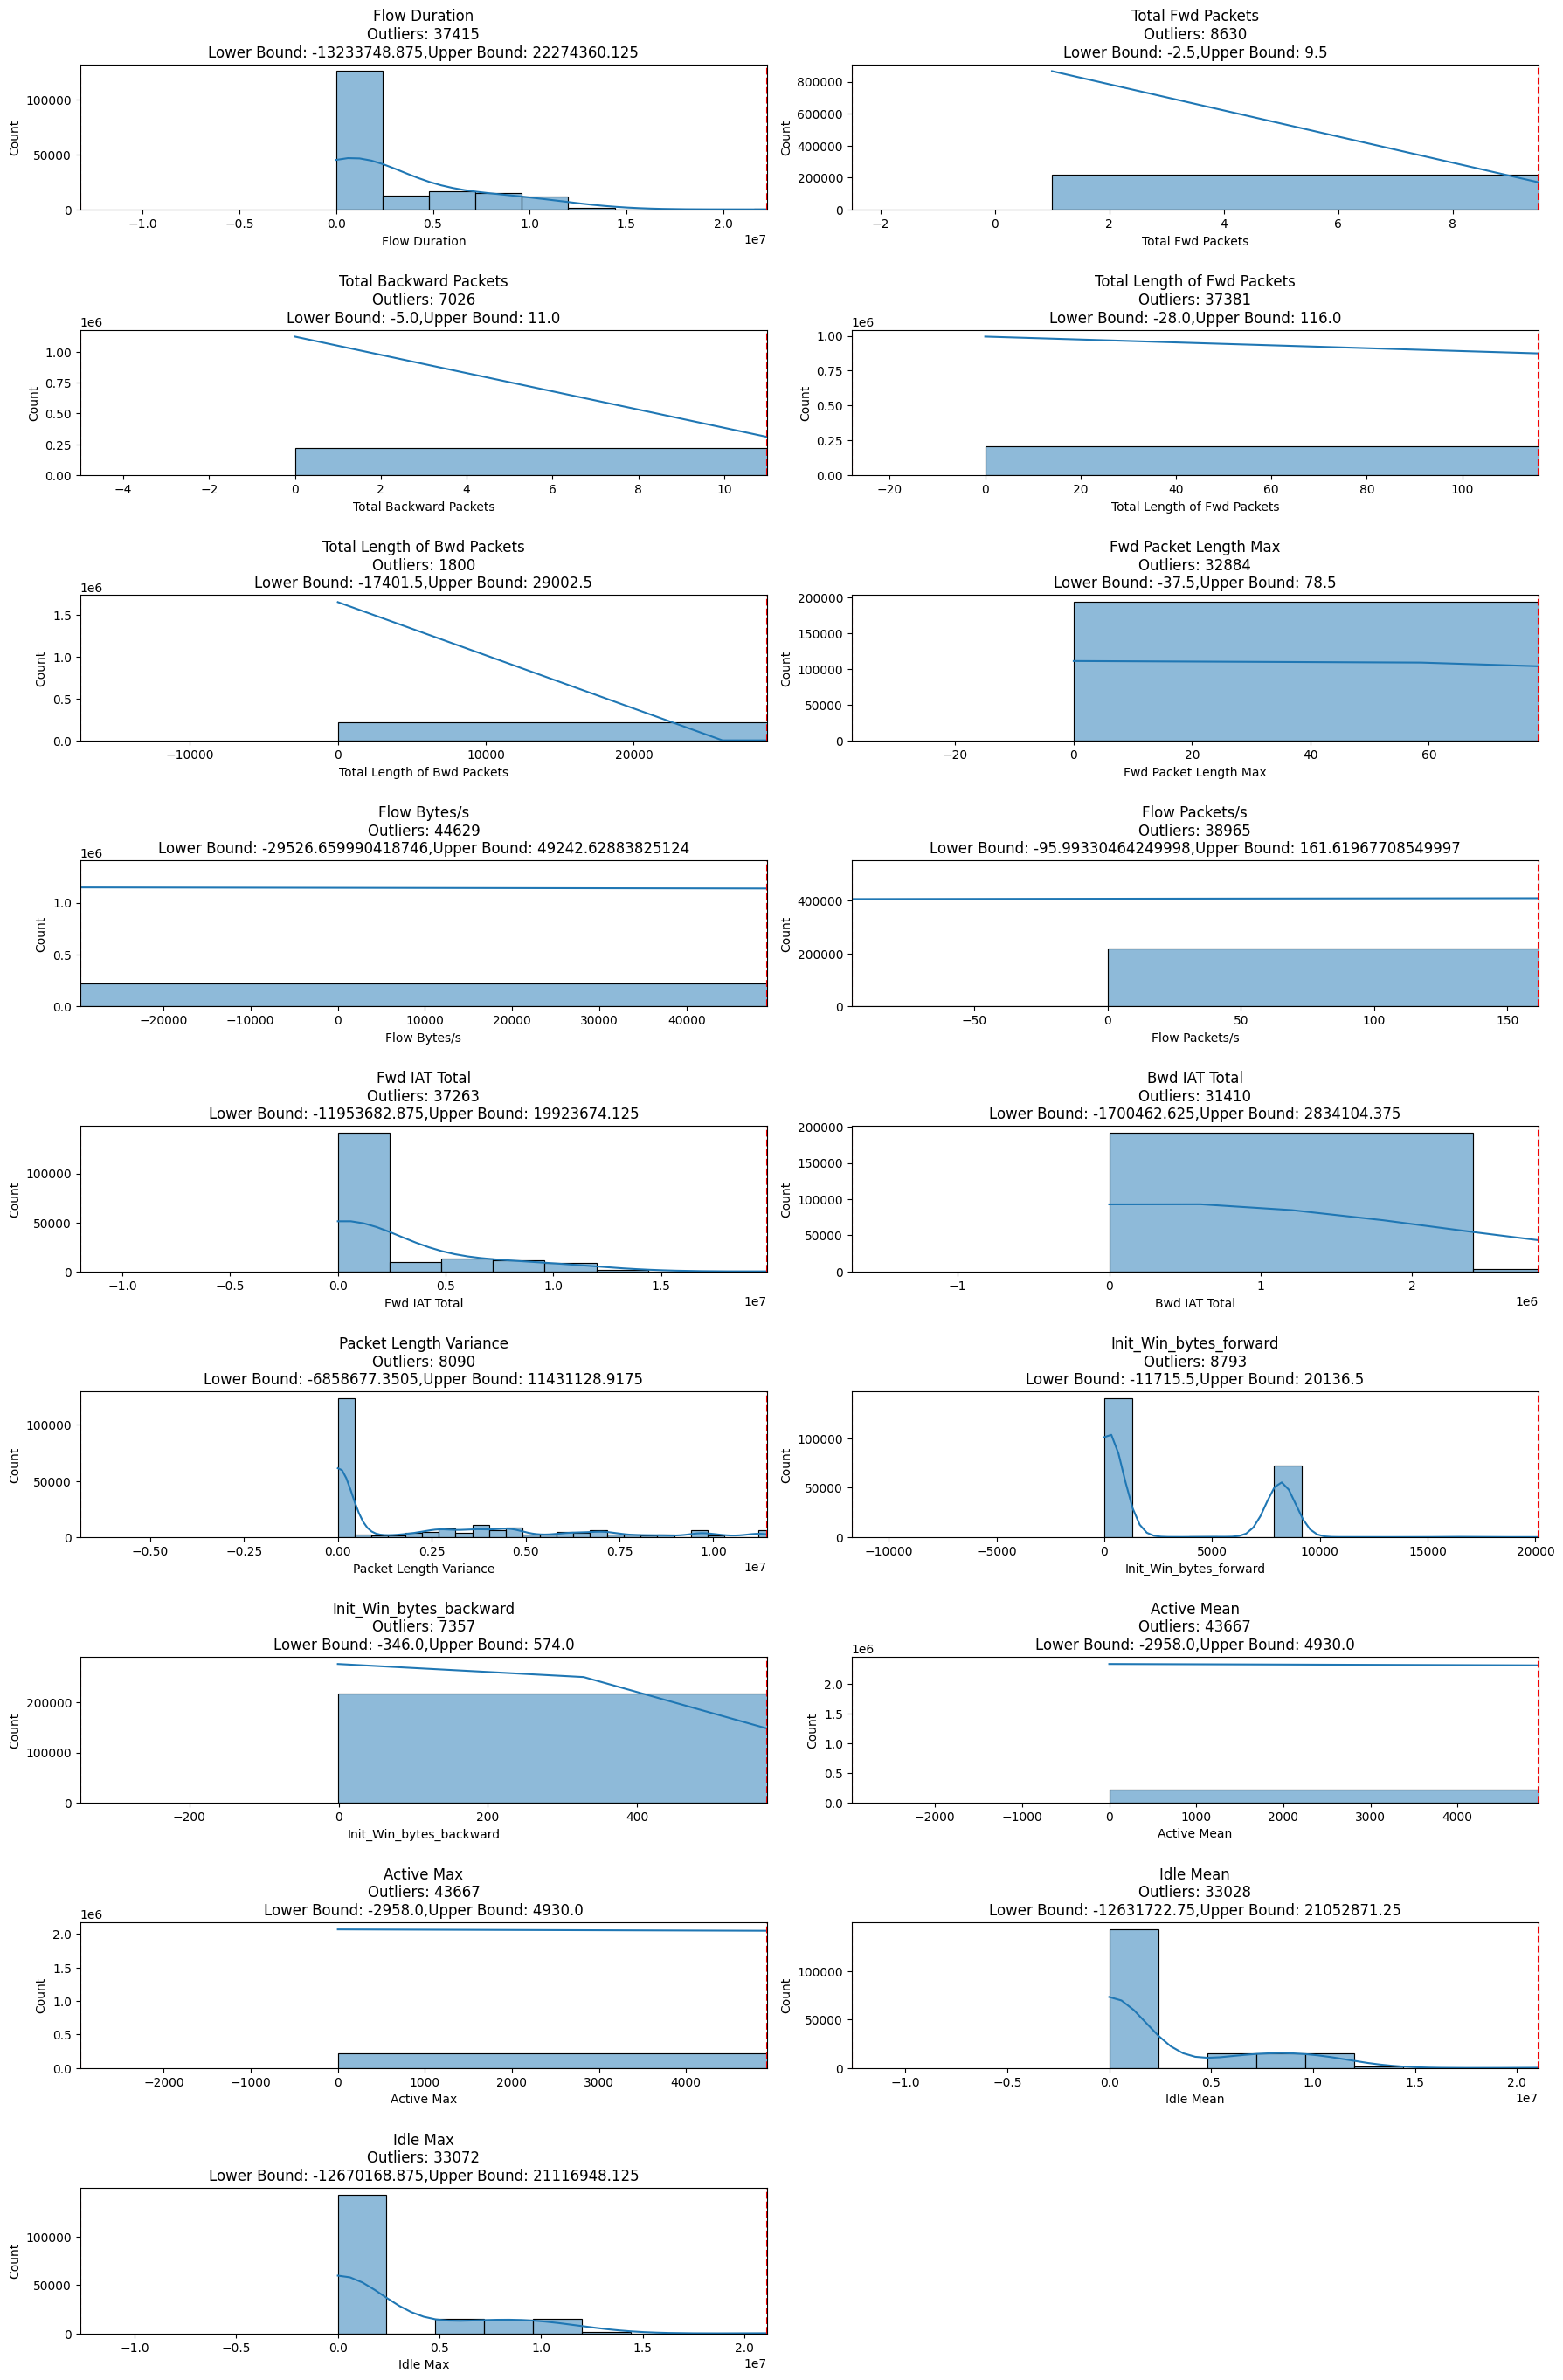

In [3]:
# List of numeric columns you want to check for outliers
outliers_detect_cols = [
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
    'Fwd Packet Length Max', 'Bwd Packet Length Max',
    'Flow Bytes/s', 'Flow Packets/s',
    'Fwd IAT Total', 'Bwd IAT Total',
    'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
    'Average Packet Size',
    'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
    'Active Mean', 'Active Max', 'Idle Mean', 'Idle Max'
]

# Dictionary to store computed outlier details for each column
outlier_details = {}

# Number of plots per row in the figure
cols_per_row = 2
# Compute number of required rows based on total columns to be plotted
rows = int(np.ceil(len(outliers_detect_cols) / cols_per_row))

# Create a figure and a grid of subplots (axes)
fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, rows * 3))
# Flatten the axes array for easy  indexing ( 2D to 1D)
axes = axes.flatten()

# Initialize figure index to track subplot positions
fig_index = 0

# Loop through each column in your selected numeric columns
for i, col in enumerate(outliers_detect_cols):
    
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds for detecting outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count how many values are outside these bounds (i.e., outliers)
    outlier_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()

    # Store outlier detection info in the dictionary
    outlier_details[col] = {
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers Found': outlier_count,
        '% of Data': outlier_count / len(df) * 100  
    }

    # If outliers exist, plot the histogram for this column
    if outlier_count > 0:
        # Draw histogram with KDE curve for the column on current subplot
        sns.histplot(df[col], bins=50, kde=True, ax=axes[fig_index])
        
        # Draw vertical lines at lower and upper outlier bounds
        axes[fig_index].axvline(lower_bound, color='red', linestyle='--')
        axes[fig_index].axvline(upper_bound, color='red', linestyle='--')
        
        # Set x-axis limits from 1st to 99th percentile to zoom in and avoid extreme outliers skewing the plot
        # axes[fig_index].set_xlim(df[col].quantile(0.00), df[col].quantile(1))
        axes[fig_index].set_xlim(lower_bound, upper_bound)

        # Set the subplot title with column name and number of outliers
        axes[fig_index].set_title(f"{col}\nOutliers: {outlier_count}\nLower Bound: {lower_bound},Upper Bound: {upper_bound}")
        
        # Move to the next subplot position
        fig_index += 1

# Remove any empty subplots remaining after plotting
for j in range(fig_index, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlapping plots and labels
fig.tight_layout()

# Show the final figure with all the subplots
plt.show()


In [4]:
# Convert the outlier details dictionary to a DataFrame for clean summary display
outlier_report_df = pd.DataFrame(outlier_details).T
outlier_report_df = outlier_report_df.sort_values(by='Outliers Found', ascending=False)

# Display final summary DataFrame
print("\nFinal Outlier Report:")
display(outlier_report_df)



Final Outlier Report:


,Lower Bound,Upper Bound,Outliers Found,% of Data
Flow Bytes/s,-2.952666e+04,4.924263e+04,44629.0,20.005648
Active Max,-2.958000e+03,4.930000e+03,43667.0,19.574417
Active Mean,-2.958000e+03,4.930000e+03,43667.0,19.574417
Flow Packets/s,-9.599330e+01,1.616197e+02,38965.0,17.466671
Flow Duration,-1.323375e+07,2.227436e+07,37415.0,16.771860
Total Length of Fwd Packets,-2.800000e+01,1.160000e+02,37381.0,16.756619
Fwd IAT Total,-1.195368e+07,1.992367e+07,37263.0,16.703723
Idle Max,-1.267017e+07,2.111695e+07,33072.0,14.825042
Idle Mean,-1.263172e+07,2.105287e+07,33028.0,14.805318
Fwd Packet Length Max,-3.750000e+01,7.850000e+01,32884.0,14.740768


### 📊 Outlier Visualization Summary

### 🔍 Key Observations:

- **Most features show heavy positive skewness (right skew)**  
  → *Meaning*: Majority of values are concentrated near the lower end (left side) of the distribution, while a few extreme values stretch far to the right.

- In **`Total Fwd Packets`** and **`Total Backward Packets`**:
  - A **tall rectangular bar at the far left** of the histogram represents a huge number of records with small packet counts (e.g., 0–5 packets).
  - This suggests **most network flows have very few packets**.
  - The **blue KDE curve peaks steeply at the start and drops rapidly**, reflecting the concentration of small values.

- Several features, including:
  - `Flow Duration`
  - `Flow Bytes/s`
  - `Active Max`
  
  ...show a **large number of outliers**, indicating highly skewed distributions or rare/extreme network events (potential anomalies or attacks).

- Features like:
  - `Packet Length Mean`
  - `Packet Length Std`
  - `Average Packet Size`
  
  ...have **negligible or no outliers**, indicating these are relatively stable and consistently distributed.

---

### 📌 Conclusion :

- 📊 The dataset is **highly imbalanced and positively skewed**.
- **Outlier handling and data transformation** are recommended before proceeding with model building.
- ⚠️ **Caution**:  
  In network intrusion detection datasets, outliers might actually represent important attack patterns.  
  Removing too many outliers (especially when they constitute over 10–20% of the data) risks losing valuable information.

### 4. Skewness Check and Transformation

Skewness refers to the asymmetry of the data distribution.

- **Positive Skew (Right Skew)**: Long tail on the right side (common in network traffic or financial data).
- **Negative Skew (Left Skew)**: Long tail on the left side.

#### 📊 Why Check for Skewness?
- Many machine learning models assume normal (symmetrical) distribution.
- Skewed data can distort model performance and feature importance.

#### 📈 What We’ll Do:
- Check skewness using `.skew()` method.
- Visualize histograms/KDE for highly skewed features.

In [ ]:
# Check skewness for numerical columns
skewness = df.select_dtypes(include=['int64', 'float64']).skew().sort_values(ascending=False)

# Display skewed features
print("Features with high skewness (> 1 or < -1):")
display(skewness[abs(skewness) > 1])


In [ ]:
# Select top 6 highly skewed features
skewed_features = skewness[abs(skewness) > 1].index[:6]

cols_per_row = 2
rows = int(np.ceil(len(skewed_features) / cols_per_row))

fig, axes = plt.subplots(rows, cols_per_row, figsize=(10, rows * 4))
axes = axes.flatten()

for i, col in enumerate(skewed_features):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


In [ ]:

# Identify skewed features with |skewness| > 1
skewed_features = skewness[abs(skewness) > 1].index.tolist()

# Apply Yeo-Johnson transformation (handles zero and negative values)
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
df[skewed_features] = pt.fit_transform(df[skewed_features])

# Recheck skewness after transformation
new_skewness = df[skewed_features].skew().sort_values(ascending=False)
print("Skewness after transformation:")
print(new_skewness)


### 5. Correlation Analysis
   
    - In this step, we analyze the relationships between numerical features using Pearson’s correlation coefficient.
Highly correlated features (|r| > 0.90) can cause:

⚠️ Multicollinearity in regression-based models

⚠️ Redundant information, increasing overfitting risk

⚠️ Misleading feature importance rankings

To manage this, we identify and carefully remove one feature from each highly correlated pair.

- Bright Yellow = strong positive correlation (close to +1)

- Dark Purple = strong negative correlation (close to -1)

- Orange/Magenta shades = moderate correlation

In [5]:
# Select numeric columns
numeric_col = df.select_dtypes(include=['int64', 'float64'])

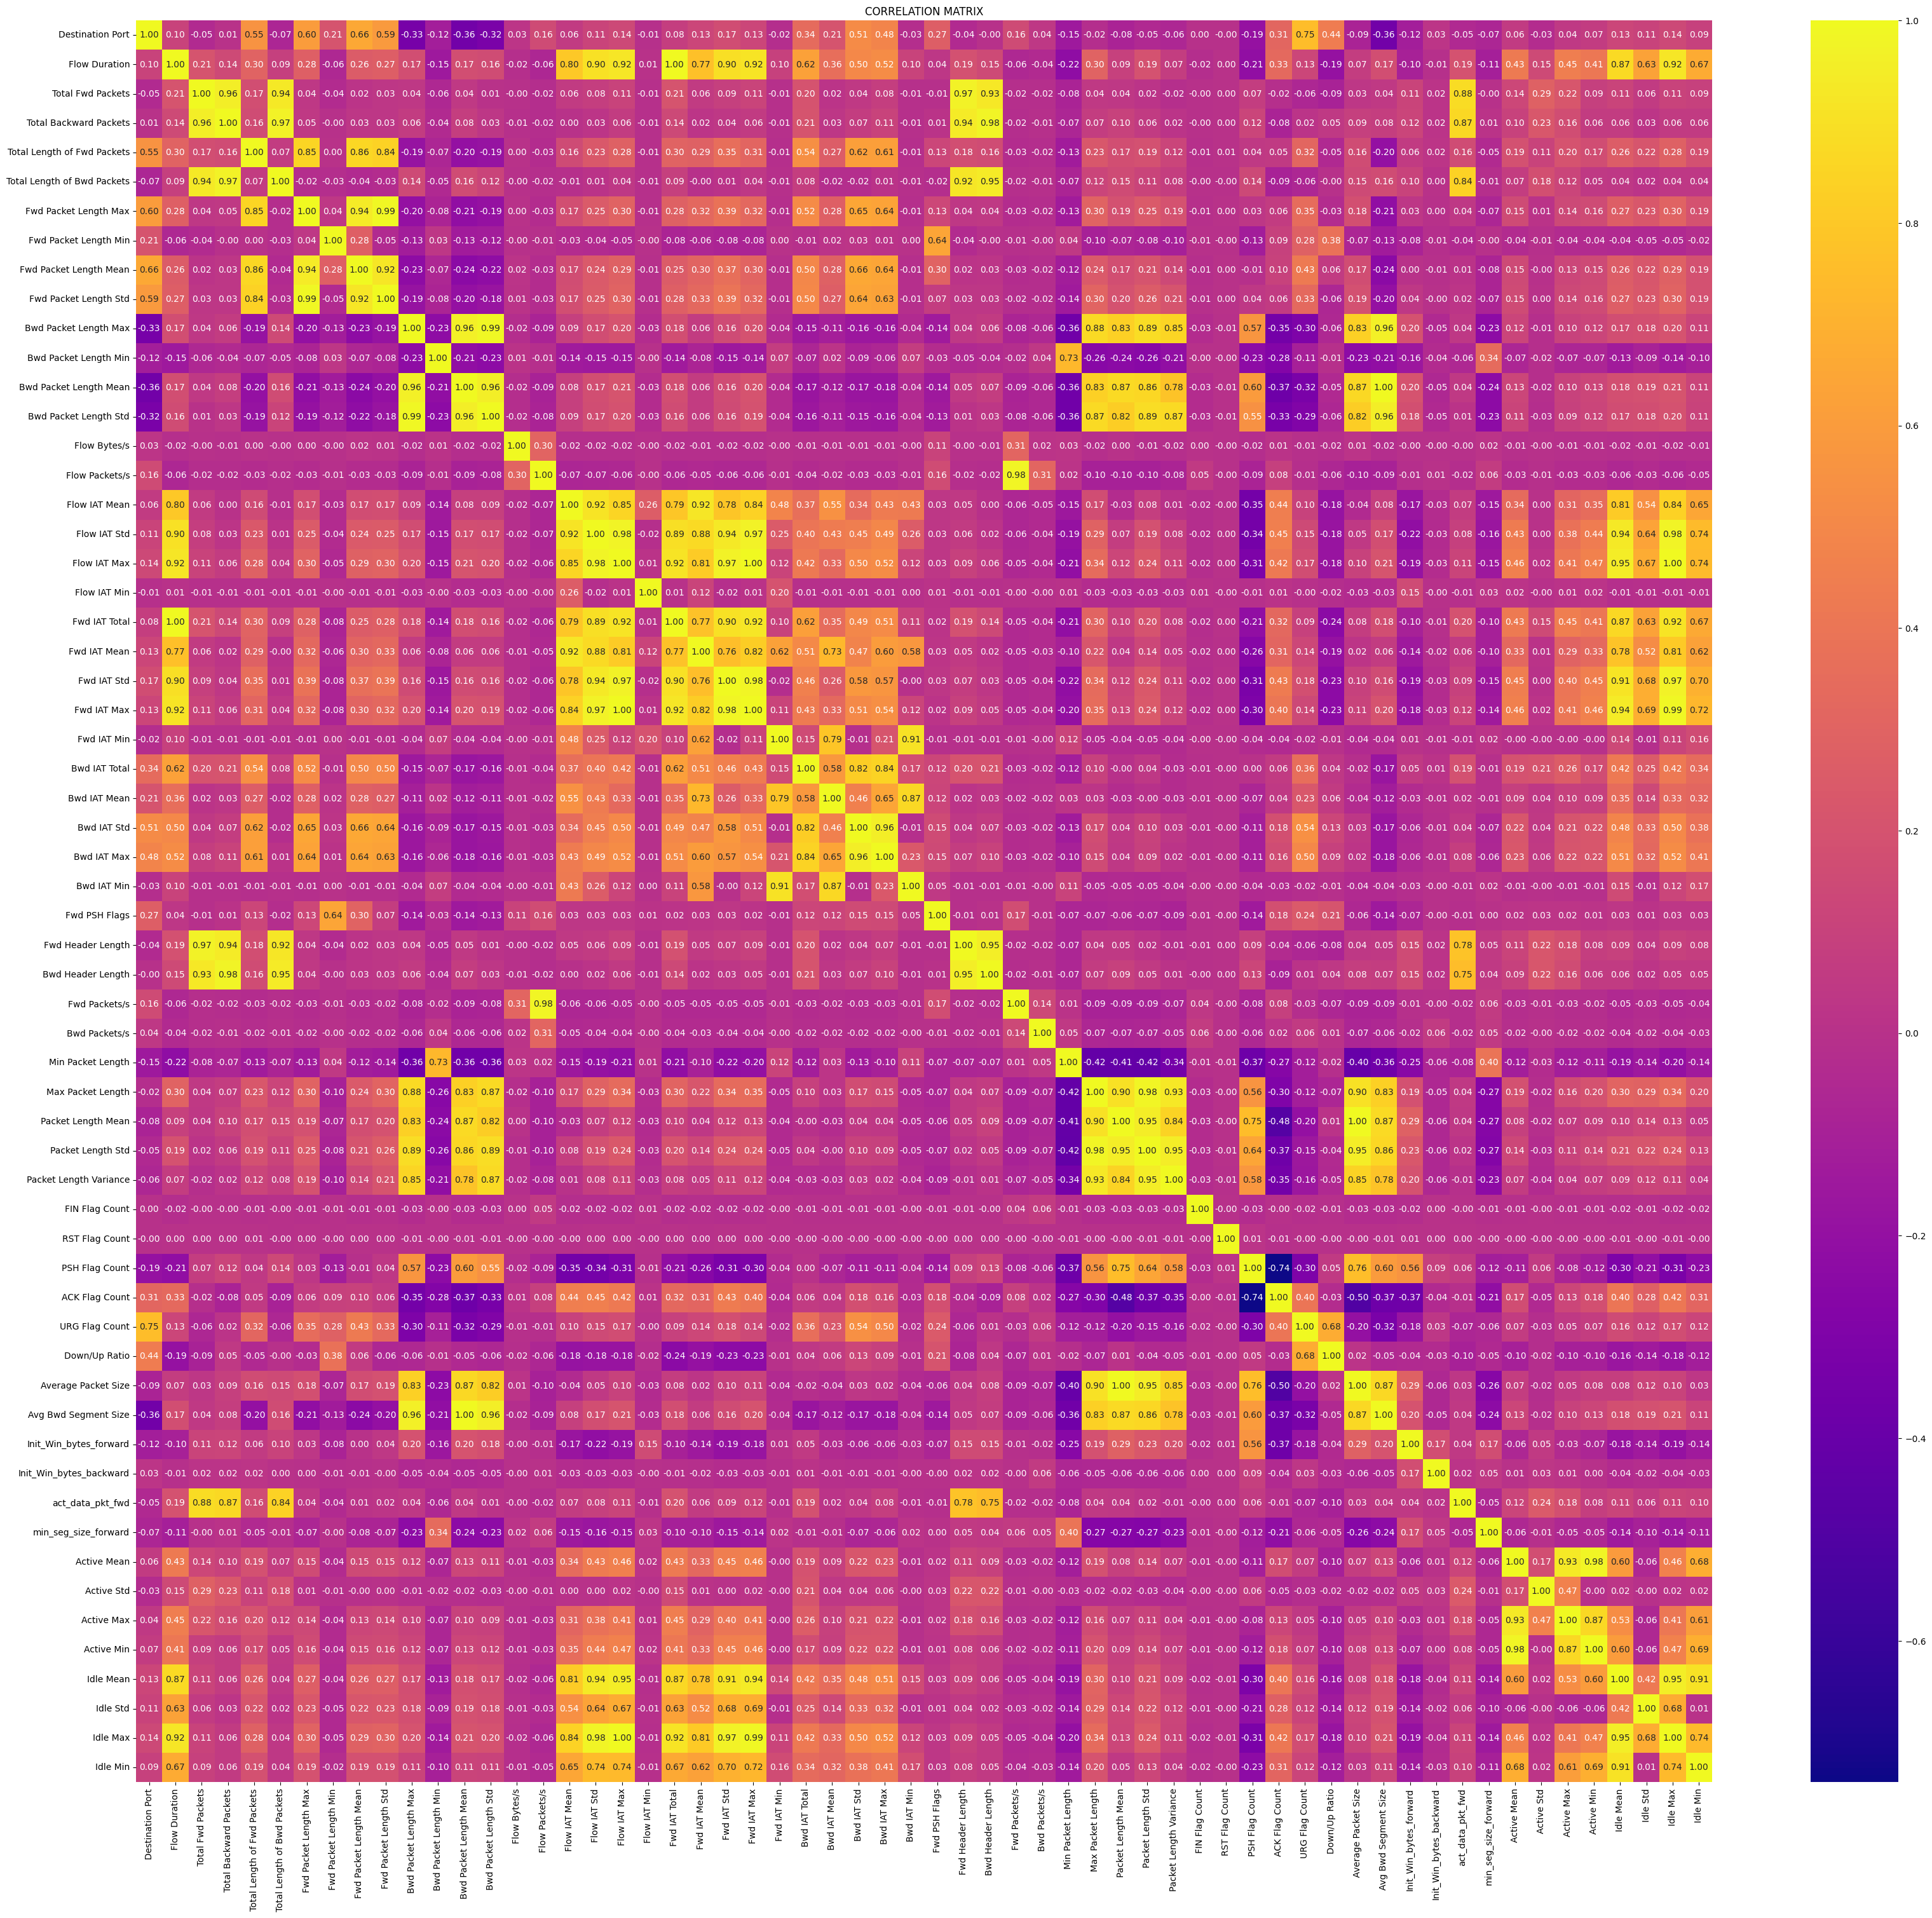

In [6]:
# Correlation matrix
corr_matrix = numeric_col.corr()

# Visualize correlation matrix
plt.figure(figsize=(40, 36))
sns.heatmap(corr_matrix, annot=True, cmap='plasma', fmt='.2f')
plt.title("CORRELATION MATRIX")
plt.show()

In [7]:

#  Find absolute correlations excluding self-correlation (1.0)
high_corr = corr_matrix.abs().unstack().sort_values(ascending=False)
high_corr = high_corr[high_corr < 1]

# Show top 20 highly correlated feature pairs
print("Top 20 highly correlated feature pairs:")
display(high_corr.head(20))


Top 20 highly correlated feature pairs:


Average Packet Size    Packet Length Mean       0.999354
Packet Length Mean     Average Packet Size      0.999354
Flow IAT Max           Idle Max                 0.997261
Idle Max               Flow IAT Max             0.997261
Fwd IAT Total          Flow Duration            0.997050
Flow Duration          Fwd IAT Total            0.997050
Flow IAT Max           Fwd IAT Max              0.995271
Fwd IAT Max            Flow IAT Max             0.995271
                       Idle Max                 0.992974
Idle Max               Fwd IAT Max              0.992974
Bwd Packet Length Std  Bwd Packet Length Max    0.992641
Bwd Packet Length Max  Bwd Packet Length Std    0.992641
Fwd Packet Length Max  Fwd Packet Length Std    0.991667
Fwd Packet Length Std  Fwd Packet Length Max    0.991667
Packet Length Std      Max Packet Length        0.983897
Max Packet Length      Packet Length Std        0.983897
Active Mean            Active Min               0.982662
Active Min             Active M

In [8]:
# Absolute correlation matrix
corr_matrix_abs = numeric_col.corr().abs()

# Create upper triangle mask (ignore duplicate pairs)
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))

# Identify highly correlated pairs (|r| > 0.90)
high_corr_pairs = [(col, row) for col in upper.columns for row in upper.index if upper.loc[row, col] > 0.90]

# Track which feature is paired with what
high_corr_features = {pair[0]: pair[1] for pair in high_corr_pairs}

# Create a set for columns to drop
to_drop = set()

print("\nCorrelated feature pairs (kept : dropped):")
for k, v in high_corr_features.items():
    print(f"{k}  :  {v}")



Correlated feature pairs (kept : dropped):
Total Backward Packets  :  Total Fwd Packets
Total Length of Bwd Packets  :  Total Backward Packets
Fwd Packet Length Mean  :  Fwd Packet Length Max
Fwd Packet Length Std  :  Fwd Packet Length Mean
Bwd Packet Length Mean  :  Bwd Packet Length Max
Bwd Packet Length Std  :  Bwd Packet Length Mean
Flow IAT Std  :  Flow IAT Mean
Flow IAT Max  :  Flow IAT Std
Fwd IAT Total  :  Flow IAT Max
Fwd IAT Mean  :  Flow IAT Mean
Fwd IAT Std  :  Flow IAT Max
Fwd IAT Max  :  Fwd IAT Std
Bwd IAT Max  :  Bwd IAT Std
Bwd IAT Min  :  Fwd IAT Min
Fwd Header Length  :  Total Length of Bwd Packets
Bwd Header Length  :  Fwd Header Length
Fwd Packets/s  :  Flow Packets/s
Packet Length Mean  :  Max Packet Length
Packet Length Std  :  Packet Length Mean
Packet Length Variance  :  Packet Length Std
Average Packet Size  :  Packet Length Std
Avg Bwd Segment Size  :  Bwd Packet Length Std
Active Max  :  Active Mean
Active Min  :  Active Mean
Idle Mean  :  Fwd IAT Max
Idle 

In [9]:
# For each highly correlated pair, drop one (arbitrarily dropping col2 here)
for col1, col2 in high_corr_pairs:
    if col1 not in to_drop and col2 not in to_drop:
        to_drop.add(col2)

# Display final drop list and correlated pairs
print("Features to drop due to high correlation (|r| > 0.90):")
print(to_drop)

df_reduced = df.drop(columns=to_drop)


Features to drop due to high correlation (|r| > 0.90):
{'Flow IAT Mean', 'Flow Packets/s', 'Flow Duration', 'Bwd IAT Std', 'Flow IAT Max', 'Fwd Header Length', 'Packet Length Std', 'Fwd Packet Length Mean', 'Packet Length Mean', 'Total Fwd Packets', 'Fwd IAT Total', 'Fwd IAT Min', 'Bwd Packet Length Mean', 'Flow IAT Std', 'Total Length of Bwd Packets', 'Bwd Packet Length Std', 'Total Backward Packets', 'Fwd IAT Std', 'Idle Mean', 'Fwd Packet Length Max', 'Fwd IAT Max', 'Bwd Packet Length Max', 'Active Mean', 'Max Packet Length'}


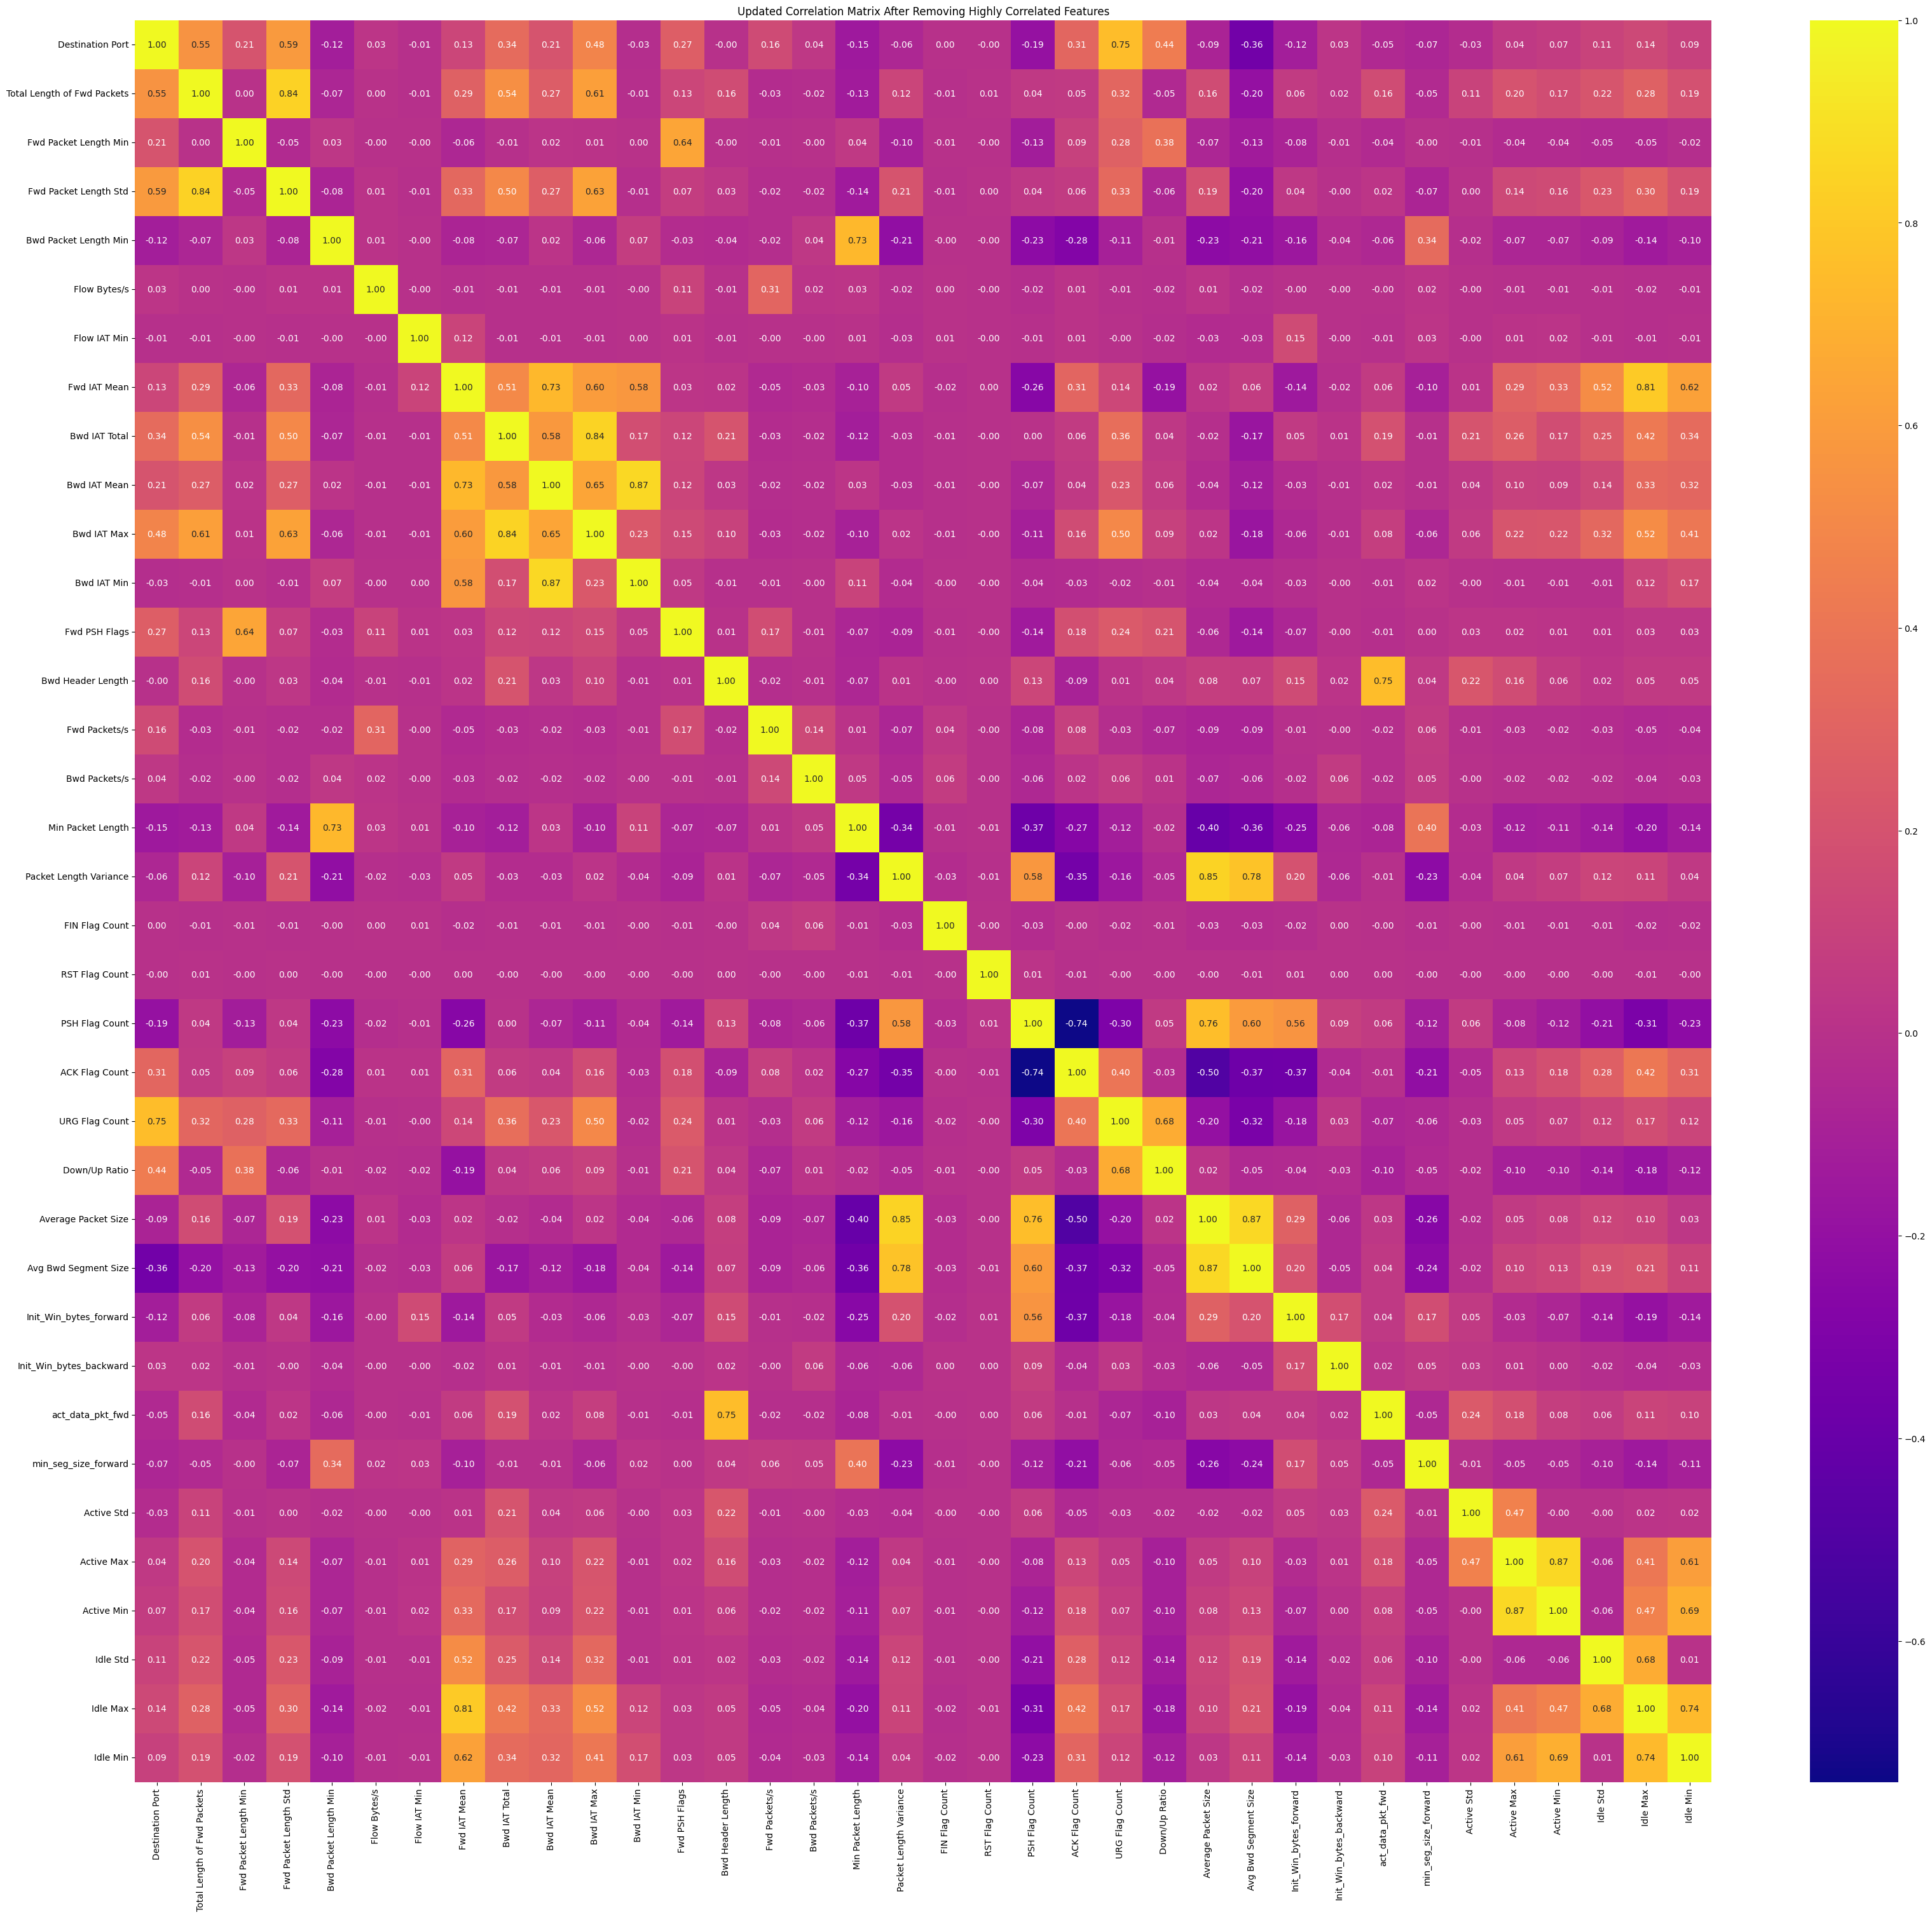

In [10]:
# Correlation matrix for reduced dataframe
numeric_col1 = df_reduced.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_col1.corr()

# Visualize updated correlation matrix
plt.figure(figsize=(40, 36))
sns.heatmap(corr_matrix, annot=True, cmap='plasma', fmt='.2f')
plt.title("Updated Correlation Matrix After Removing Highly Correlated Features")
plt.show()


### 📊 Conclusion 

- Multiple feature pairs had a very strong correlation (|r| > 0.90).

- Notably, Total Fwd Packets and Total Length of Fwd Packets were tightly linked.

- We systematically dropped one feature from each high-correlation pair to minimize redundancy while preserving information.

- This improves model interpretability, reduces overfitting risk, and streamlines feature space.



In [11]:
# Save as CSV
df_reduced.to_csv('../data/processed/eda_network_data.csv', index=False)

## 📊 EDA Summary

- Identified and removed extreme outliers using IQR method.
- Performed correlation analysis and dropped highly correlated features (|r| > 0.90).
- Checked for feature skewness and considered transformations (log1p / Yeo-Johnson).
- Saved the cleaned dataset for modeling.
